In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch

In [2]:
earth_image = Image.open('earth_180x180.png')
num_channels = 3 # exclude alpha
earth = ((np.asarray(earth_image)[:,:,0:num_channels]/255)*2)-1 #normalized r,g,b -1 to 1
earth_bw = np.asarray(earth_image.convert('L')) #grayscale 
# image to x,y -> (r,g,b) format
xy = np.stack(np.meshgrid(np.arange(earth.shape[0]), np.arange(earth.shape[1])),axis=-1)
X_in = xy.reshape(-1,2) 
Y_out = earth[X_in[:,0],X_in[:,1]]
Y_out_bw = earth_bw[X_in[:,0],X_in[:,1]]
plt.imshow((earth+1)/2)

In [3]:
# fit image (x,y) -> (r,g,b)
num_input_nodes= X_in.shape[1]
num_hidden_units = earth.shape[0]*32

In [4]:
# using numpy
elm_hidden_weights = np.random.uniform(-1, 1, size=(num_input_nodes, num_hidden_units))
elm_bias = np.zeros(num_hidden_units, )

# fit
elm_hidden_mat = np.sin(X_in.dot(elm_hidden_weights) + elm_bias)
elm_hidden_mat_pinv = np.linalg.pinv(elm_hidden_mat)
elm_beta = elm_hidden_mat_pinv.dot(Y_out)

# test
elm_hidden_mat = np.sin(X_in.dot(elm_hidden_weights) + elm_bias)
elm_predictions = elm_hidden_mat.dot(elm_beta).reshape(earth.shape[0],earth.shape[1],3)

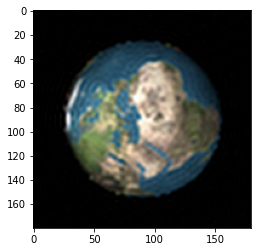

In [5]:
plt.imshow(np.clip(elm_predictions,a_min=0,a_max=1))

In [6]:
# using torch on cuda
X_in_cuda = torch.from_numpy(X_in).to(dtype=torch.float32,device='cuda')
Y_out_cuda = torch.from_numpy(Y_out).to(dtype=torch.float32,device='cuda')
Y_out_bw_cuda = torch.from_numpy(Y_out_bw).to(dtype=torch.float32,device='cuda').reshape(*Y_out_bw.shape,1)  #need matrix for torch.mm

In [7]:
elm_hidden_weights = torch.distributions.uniform.Uniform(-1,1).sample([num_input_nodes,num_hidden_units]).to(dtype=torch.float32,device='cuda')
elm_bias = torch.zeros((num_hidden_units, ), device = 'cuda')

In [8]:
# fit
elm_hidden_mat = torch.sin(torch.mm(X_in_cuda,elm_hidden_weights) + elm_bias)
elm_hidden_mat_pinv = torch.linalg.pinv(elm_hidden_mat)
elm_beta = torch.mm(elm_hidden_mat_pinv,Y_out_cuda)

In [9]:
# test
elm_hidden_mat = torch.sin(torch.mm(X_in_cuda,elm_hidden_weights) + elm_bias)
elm_predictions = torch.mm(elm_hidden_mat,elm_beta).reshape(earth.shape[0],earth.shape[1],3)

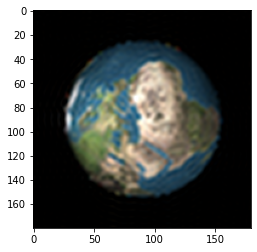

In [11]:
plt.imshow(torch.clip((elm_predictions.to('cpu')+1)/2,min=0,max=1))